# LAGS
    Joseph Antony
    22nd June 2023

In [1]:
import warnings
import numpy as np
from scipy.stats import spearmanr

from datetime import datetime, timedelta

import polars as pl
pl.enable_string_cache(True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, ccf

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [2]:
%%time

select_Cols = ['DATE_TIME', 'GEOHASH', 'NUMBER_OF_VEHICLES', 'IS_FOOTBALL_MATCH']
weather_cols = ['TEMP', 'RAIN', 'SNOW']


pl_df = (
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")
    .select(select_Cols + weather_cols)
    .with_columns(pl.col('DATE_TIME').dt.date().alias('DATE'))
).collect(streaming=True)

pl_df.head()

Wall time: 21.9 s


shape: (5, 8)
┌──────────────┬─────────┬───────────────────┬───────────────────┬──────┬──────┬──────┬────────────┐
│ DATE_TIME    ┆ GEOHASH ┆ NUMBER_OF_VEHICLE ┆ IS_FOOTBALL_MATCH ┆ TEMP ┆ RAIN ┆ SNOW ┆ DATE       │
│ ---          ┆ ---     ┆ S                 ┆ ---               ┆ ---  ┆ ---  ┆ ---  ┆ ---        │
│ datetime[ns] ┆ cat     ┆ ---               ┆ bool              ┆ f32  ┆ f32  ┆ f32  ┆ date       │
│              ┆         ┆ u16               ┆                   ┆      ┆      ┆      ┆            │
╞══════════════╪═════════╪═══════════════════╪═══════════════════╪══════╪══════╪══════╪════════════╡
│ 2020-01-01   ┆ sxkbj3  ┆ 97                ┆ false             ┆ 5.8  ┆ 0.0  ┆ 0.0  ┆ 2020-01-01 │
│ 00:00:00     ┆         ┆                   ┆                   ┆      ┆      ┆      ┆            │
│ 2020-01-01   ┆ sxkbj3  ┆ 58                ┆ false             ┆ 6.0  ┆ 0.0  ┆ 0.0  ┆ 2020-01-01 │
│ 01:00:00     ┆         ┆                   ┆                   ┆      ┆      ┆      ┆            │
│ 2020-01-01   ┆ sxkbj3  ┆ 40                ┆ false             ┆ 6.1  ┆ 0.0  ┆ 0.0  ┆ 2020-01-01 │
│ 02:00:00     ┆         ┆                   ┆                   ┆      ┆      ┆      ┆            │
│ 2020-01-01   ┆ sxkbj3  ┆ 33                ┆ false             ┆ 6.0  ┆ 0.0  ┆ 0.0  ┆ 2020-01-01 │
│ 03:00:00     ┆         ┆                   ┆                   ┆      ┆      ┆      ┆            │
│ 2020-01-01   ┆ sxkbj3  ┆ 25                ┆ false             ┆ 5.9  ┆ 0.0  ┆ 0.0  ┆ 2020-01-01 │
│ 04:00:00     ┆         ┆                   ┆                   ┆      ┆      ┆      ┆            │
└──────────────┴─────────┴───────────────────┴───────────────────┴──────┴──────┴──────┴────────────┘

#### Lagged values involve looking at past information to make predictions or gain insights about what might happen next.

#### Lagged values help us understand how past events can influence the present or future. By considering the Traffic density from the previous hour, we can kind of expect what the traffic will be like in the current or the next hour.

#### The same goes for weather events. If there was a heavy snow or rain in the previous hour, we can expect what the traffic could be like now or the next hour.

## Lag Plots
    Lag plots are a way to see if there is a relationship or pattern between a data point and its previous values. They help us understand if there is any connection or dependency between a data point and its lagged values.

    I will create hourly lag plots (lagging by 1 hour at a time) and faily lag plots (agging by 42 hours at a time).

I will use spearman correlation to assess the reltionship between Traffic density and its nth lag.

**Spearman correlation** is based on the ranks of the data rather than the actual values. This makes it more suitable for detecting and measuring relationships that follow a monotonic pattern (i.e., increasing or decreasing) but may not necessarily be linear.

In [3]:
def plot_lagplots(temp_df, interval, time_element, figsize=(12, 30), rows=None, alpha=0.1):

    if rows is None:
        if time_element=='hour': rows=8 
        else: rows=10

    fig, axes = plt.subplots(rows, 3, figsize=figsize, sharex=True, sharey=True)

    for i, ax in zip(interval, axes.flatten()):

        # To Calculate Spearman correlation between Traffic Density and its ith lag value
        a = temp_df.query(f"lag_{i}.notnull()")['NUMBER_OF_VEHICLES']
        b = temp_df.query(f"lag_{i}.notnull()")[f'lag_{i}']

        cr = spearmanr(a=a, b=b)[0]

        ax = (
            temp_df
            .plot(x='NUMBER_OF_VEHICLES', y=f'lag_{i}', kind='scatter', edgecolor='k', 
                alpha=alpha, ax=ax, color='b')
        )

        ax.scatter(y=[], x=[], label=f"SpearmanCorr: {cr:.3f}")

        ax.set_xlabel("y(t)")
        ax.set_ylabel(f"y(t+{i})")

        if time_element=='hour':
            ax.set_title(f'Lag {i} {time_element}') if i==1 else ax.set_title(f'Lag {i} {time_element}s')
        else:
            ax.set_title(f'Lag {int(i/24)} {time_element}') if i==24 else ax.set_title(f'Lag {int(i/24)} {time_element}s')

        ax.legend(fontsize=10)
        
    plt.tight_layout()
    plt.show();

In [4]:
# Comparing by hour lags (1 hour each)
interval=range(1, 25, 1)

temp_df = (
    pl_df.lazy()
    .groupby('DATE_TIME')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort('DATE_TIME')
    .with_columns([pl.col('NUMBER_OF_VEHICLES').shift(i).alias(f'lag_{i}') for i in interval])
    .collect(streaming=True)
    .to_pandas()
)

temp_df.head(10)

DATE_TIME  NUMBER_OF_VEHICLES      lag_1      lag_2      lag_3  \
0 2020-01-01 00:00:00           52.665747        NaN        NaN        NaN   
1 2020-01-01 01:00:00           46.115830  52.665747        NaN        NaN   
2 2020-01-01 02:00:00           35.004413  46.115830  52.665747        NaN   
3 2020-01-01 03:00:00           25.607281  35.004413  46.115830  52.665747   
4 2020-01-01 04:00:00           20.718147  25.607281  35.004413  46.115830   
5 2020-01-01 05:00:00           31.038610  20.718147  25.607281  35.004413   
6 2020-01-01 06:00:00           36.183673  31.038610  20.718147  25.607281   
7 2020-01-01 07:00:00           48.194705  36.183673  31.038610  20.718147   
8 2020-01-01 08:00:00           46.179261  48.194705  36.183673  31.038610   
9 2020-01-01 09:00:00           45.993381  46.179261  48.194705  36.183673   

       lag_4      lag_5      lag_6      lag_7      lag_8  ...  lag_15  lag_16  \
0        NaN        NaN        NaN        NaN        NaN  ...     NaN     NaN   
1        NaN        NaN        NaN        NaN        NaN  ...     NaN     NaN   
2        NaN        NaN        NaN        NaN        NaN  ...     NaN     NaN   
3        NaN        NaN        NaN        NaN        NaN  ...     NaN     NaN   
4  52.665747        NaN        NaN        NaN        NaN  ...     NaN     NaN   
5  46.115830  52.665747        NaN        NaN        NaN  ...     NaN     NaN   
6  35.004413  46.115830  52.665747        NaN        NaN  ...     NaN     NaN   
7  25.607281  35.004413  46.115830  52.665747        NaN  ...     NaN     NaN   
8  20.718147  25.607281  35.004413  46.115830  52.665747  ...     NaN     NaN   
9  31.038610  20.718147  25.607281  35.004413  46.115830  ...     NaN     NaN   

   lag_17  lag_18  lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
5     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
6     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
7     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
8     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
9     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[10 rows x 26 columns]

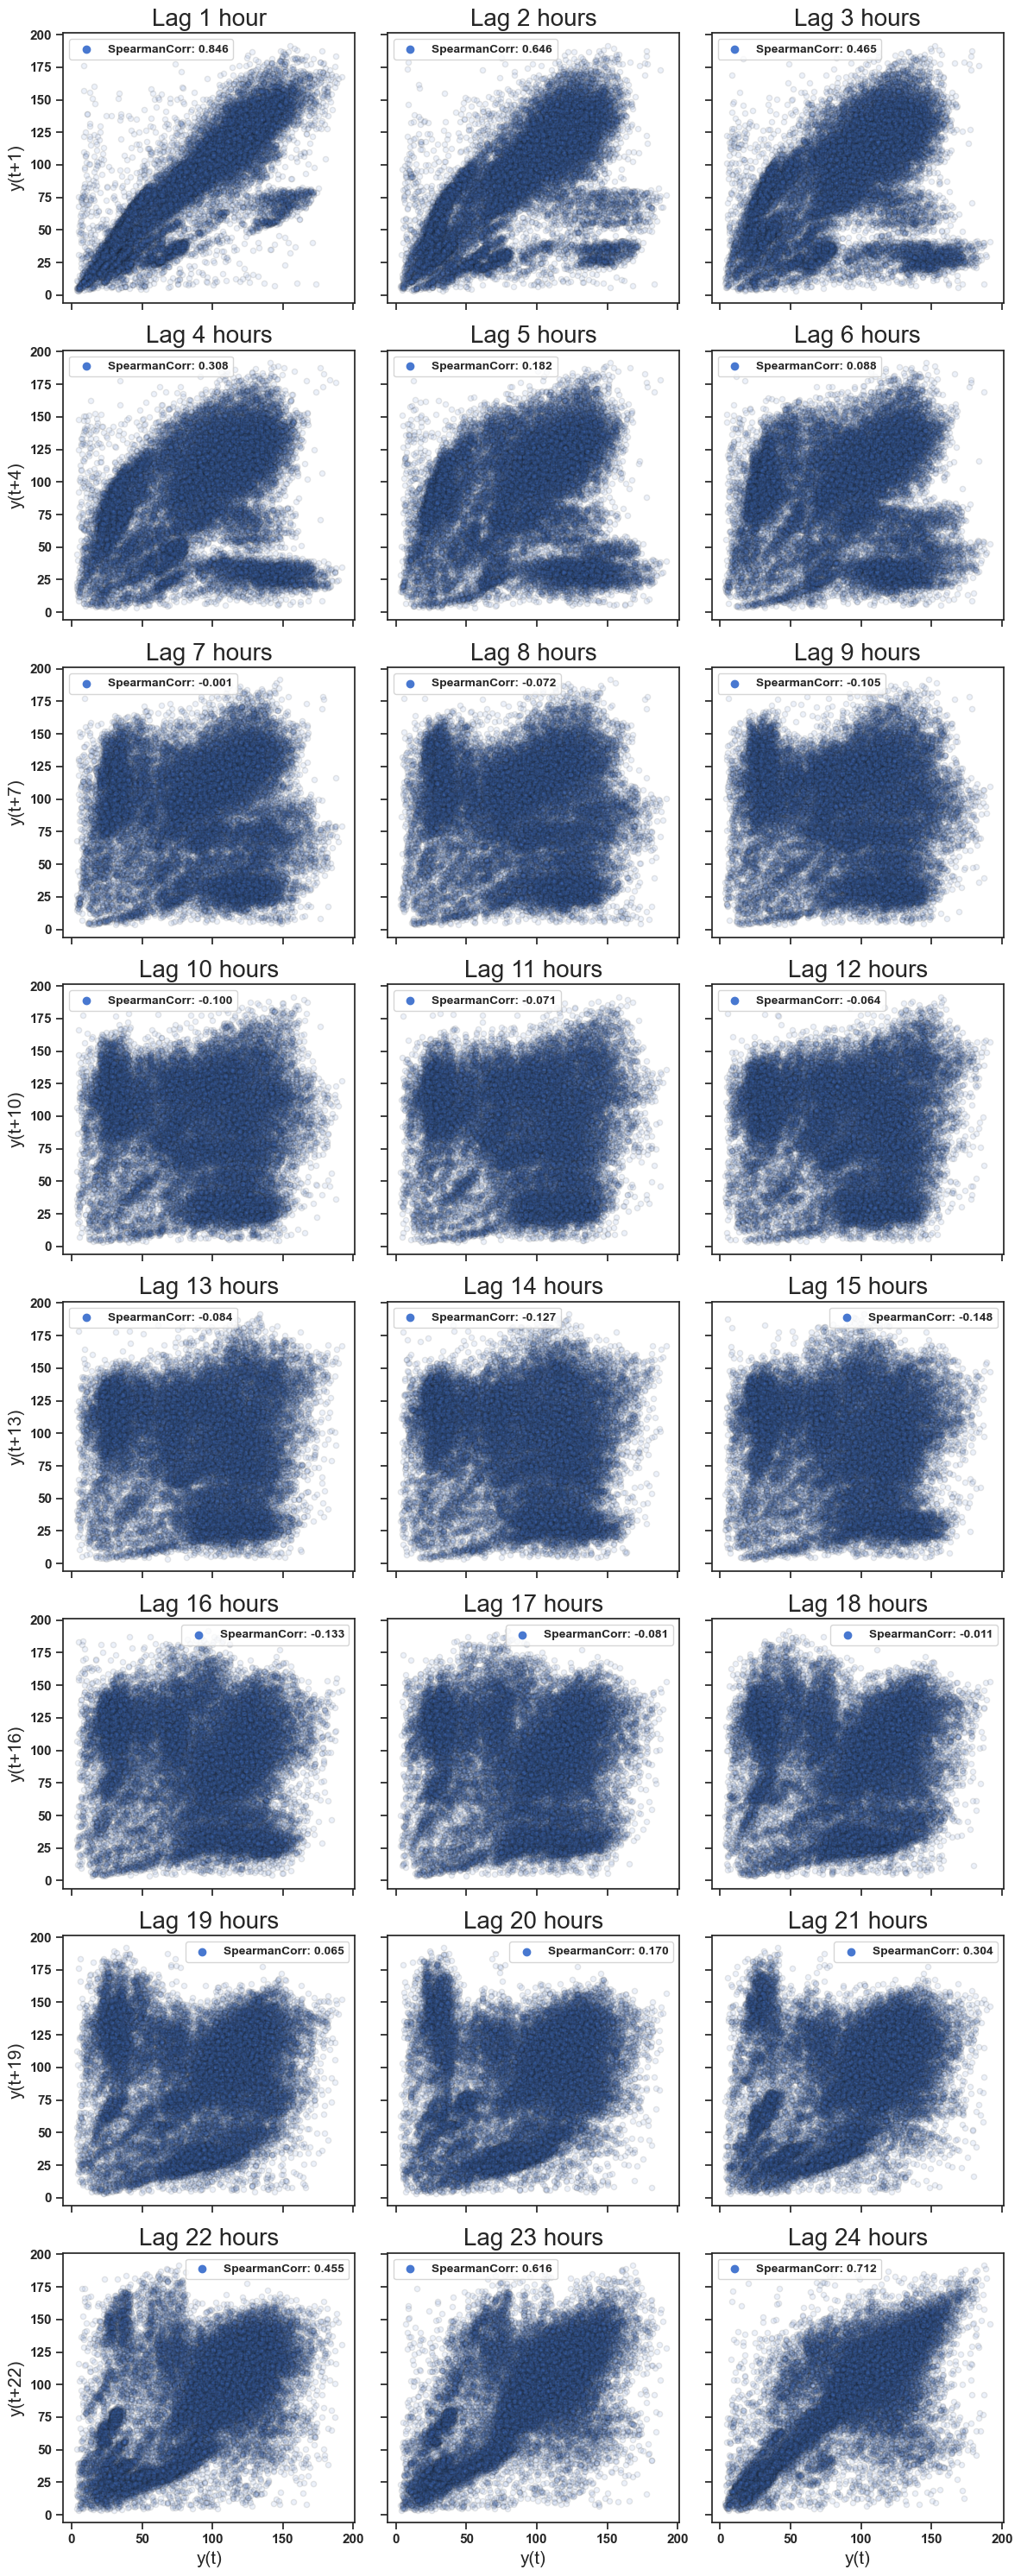

In [5]:
plot_lagplots(temp_df=temp_df, interval=interval, time_element='hour')

    If you observe that the first lag in the hourly lag plots, there is a strong Spearman correlation compared to all other lags. This indictes that a particular relationship between the current hour and the hour immediately preceding it.

    It may suggest that the traffic conditions in the current hour are strongly influenced by the conditions observed in the previous hour.

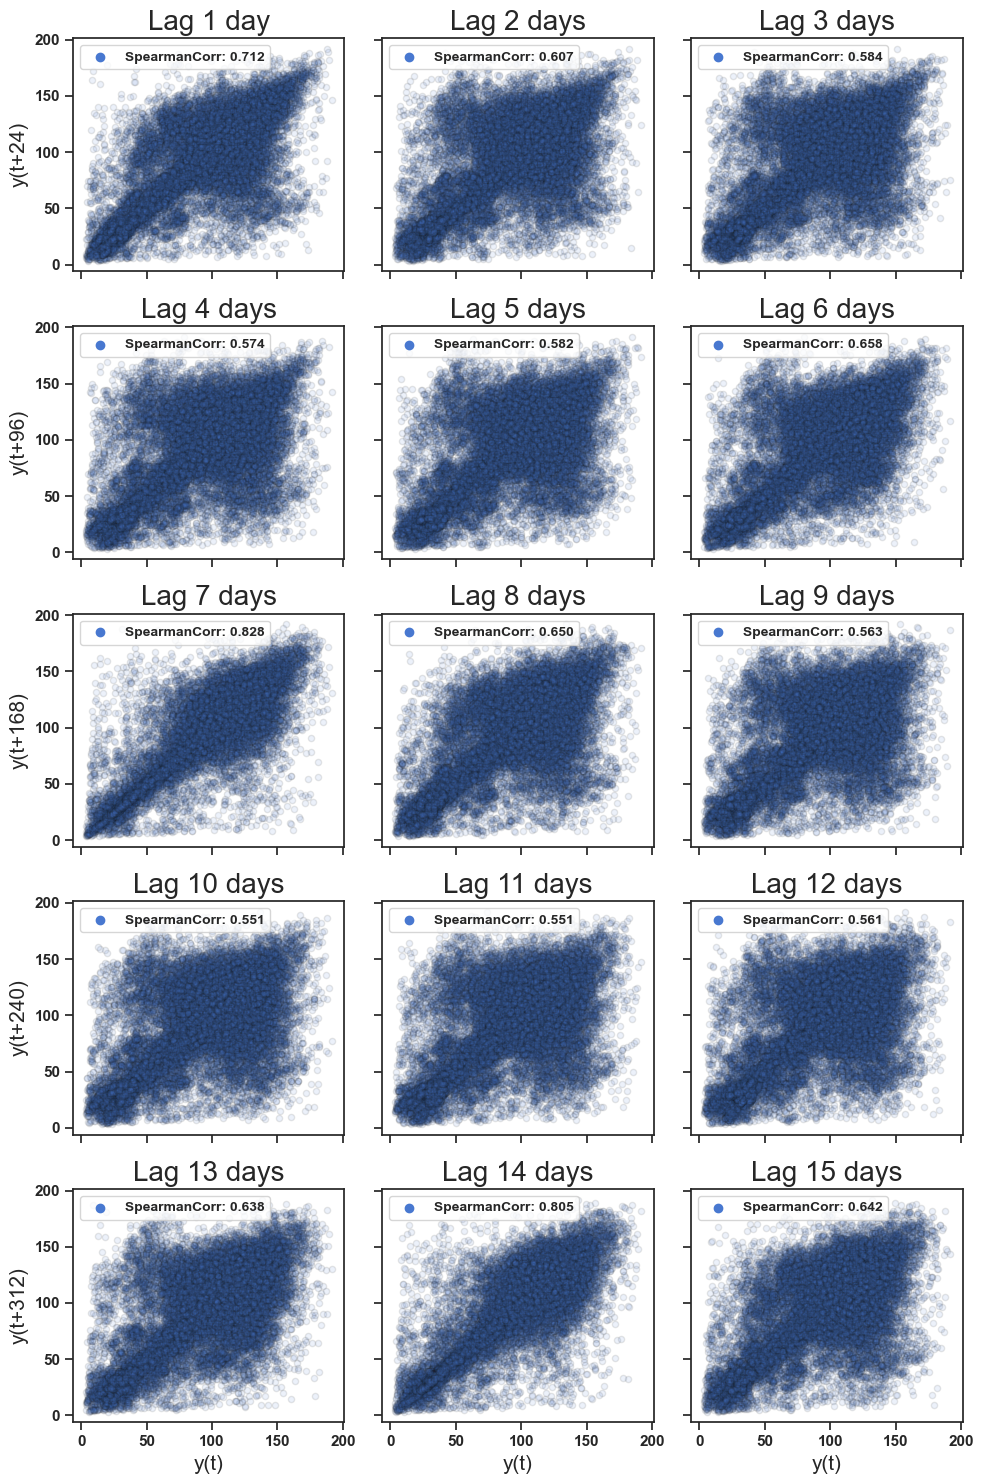

In [14]:
# Comparing by day lags (24 hours each)
interval=range(24, 24*31, 24)

temp_df = (
    pl_df.lazy()
    .groupby('DATE_TIME')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort('DATE_TIME')
    .with_columns([pl.col('NUMBER_OF_VEHICLES').shift(i).alias(f'lag_{i}') for i in interval])
    .collect(streaming=True)
    .to_pandas()
)

plot_lagplots(temp_df=temp_df, interval=interval, time_element='day', rows=5, figsize=(10, 15))

    Similarly to the first hour, when lagging at 24 hour interval, we can notice a string spearman correlation at the 24th hour (previous day traffic) and at the 168th hour (previous week traffic). 

### ACF & PACF

#### ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) are additional tools used to assess the relationships between lagged variables in a time series analysis. They provide complementary information to lag plots and can help confirm or provide further insights into what we observe in lagged plots.

    I will only use data from 2023 to plot ACF and PACF.

In [7]:
hourly_td = (
    pl_df.lazy()
    .filter(pl.col('DATE_TIME').dt.year() >=2023)
    .groupby('DATE_TIME')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort('DATE_TIME')
    .collect(streaming=True)
    .to_pandas()
    .set_index('DATE_TIME')
)

hourly_td.head()

NUMBER_OF_VEHICLES
DATE_TIME                              
2023-01-01 00:00:00           51.672366
2023-01-01 01:00:00           46.783232
2023-01-01 02:00:00           36.794264
2023-01-01 03:00:00           28.467733
2023-01-01 04:00:00           25.174297

##### ACF and PACF assume that the time series data is **stationary**. Stationarity means that the statistical properties of the data, such as mean and variance, remain constant over time. It is essential for accurate interpretation of ACF and PACF results. If your data is non-stationary, it may require preprocessing or transformation to achieve stationarity before applying ACF and PACF.

#### There, MSTL (multiple seasonal-trend components decomposition) will be used to remove the trend and seasonality components. We will only use the resicual component.

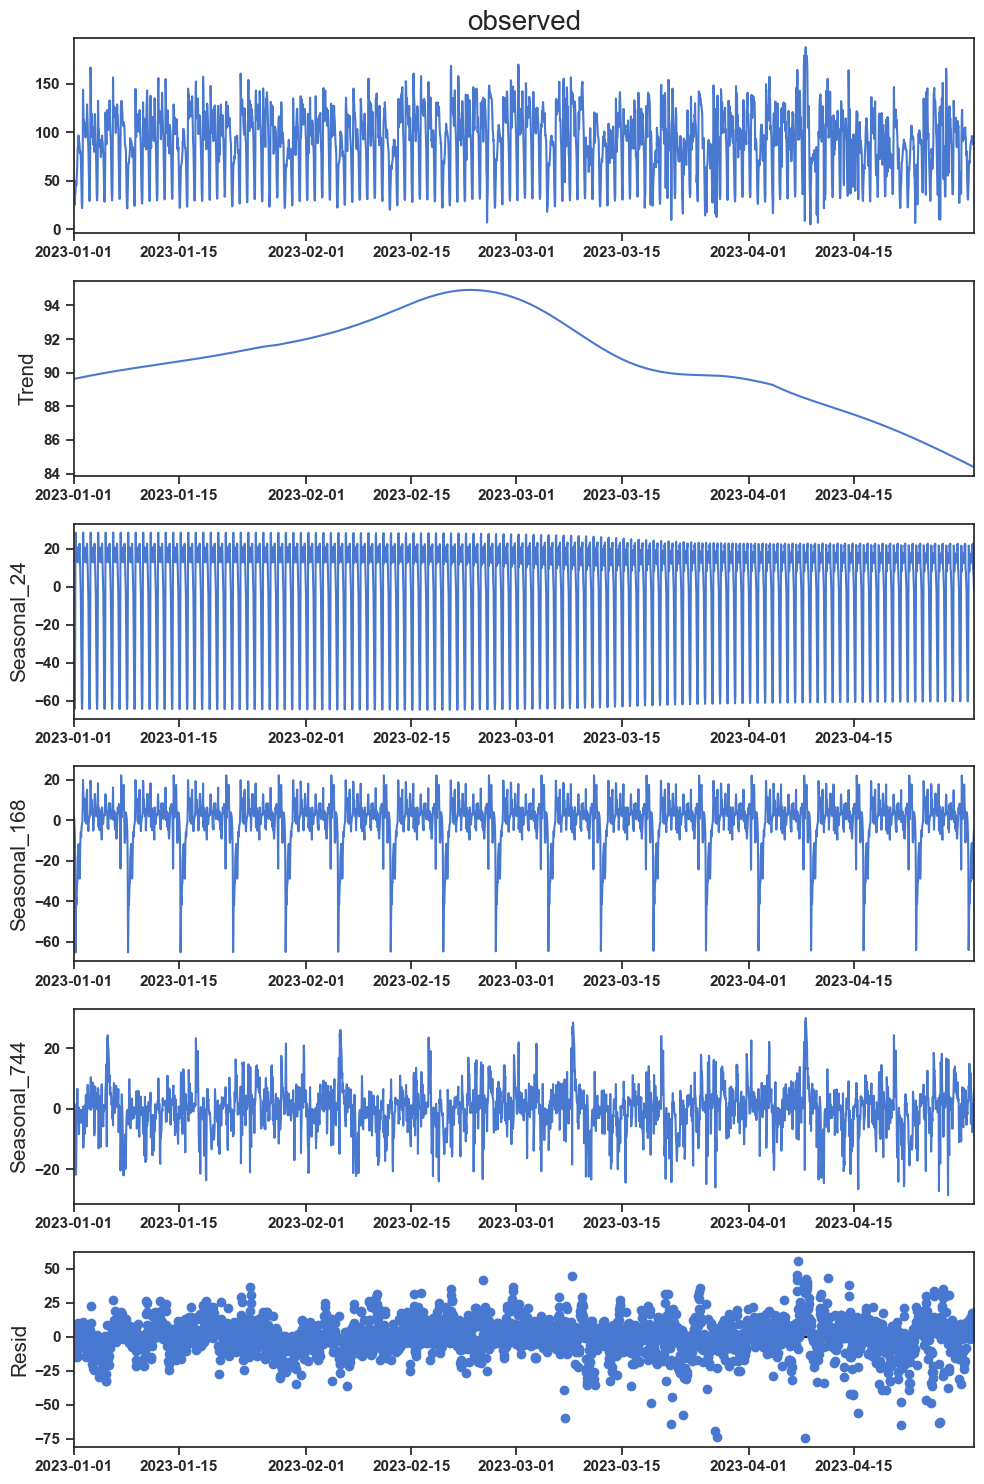

In [8]:
# Decomposing Traffic Density (2023 only)
mstl = MSTL(hourly_td["NUMBER_OF_VEHICLES"], 
            periods=(24, 24*7, 24*31), # Hourly, weekly seasonality
            windows=[101, 51, 11],
            stl_kwargs={
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
           )

res=mstl.fit()

fig = res.plot()
fig.set_size_inches((10, 15))
fig.tight_layout()

In [9]:
# Using the residuals
hourly_td['TD_resid'] = res.resid
hourly_td.head()

NUMBER_OF_VEHICLES   TD_resid
DATE_TIME                                         
2023-01-01 00:00:00           51.672366 -14.737736
2023-01-01 01:00:00           46.783232   0.722584
2023-01-01 02:00:00           36.794264   4.518975
2023-01-01 03:00:00           28.467733   6.075257
2023-01-01 04:00:00           25.174297   6.714782

##### One of the pre-requisites for doing ACF or PACF is ensuring the time series are stationary. In order to ensure all time series are stationary, Augmented Dickey-Fuller test will be used.

##### "The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root."

In [10]:
def ADFtest(series, alpha):
    
    result = adfuller(series, autolag='AIC')
    p_val = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {p_val:.10f}')
    print()
    
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    
    
    print()
    if p_val < alpha:
        print(f"P-Value lower than alpha. Unit root does not exist. Hence Time series is Stationary")
    else:
        print(f"P-Value greater than alpha. Unit root does exist. Hence Time series is Not Stationary")

In [11]:
#check for stationarity for CAQI_resid
ADFtest(series=hourly_td['TD_resid'], alpha=0.01)

ADF Statistic: -7.488568520421444
n_lags: 4.5694197767690997e-11
p-value: 0.0000000000

Critial Values:
   1%, -3.4326417322091425
Critial Values:
   5%, -2.8625525306028794
Critial Values:
   10%, -2.567308999840132

P-Value lower than alpha. Unit root does not exist. Hence Time series is Stationary


##### The de-trended and de-seasonalized time series (the residuals) is stationary.

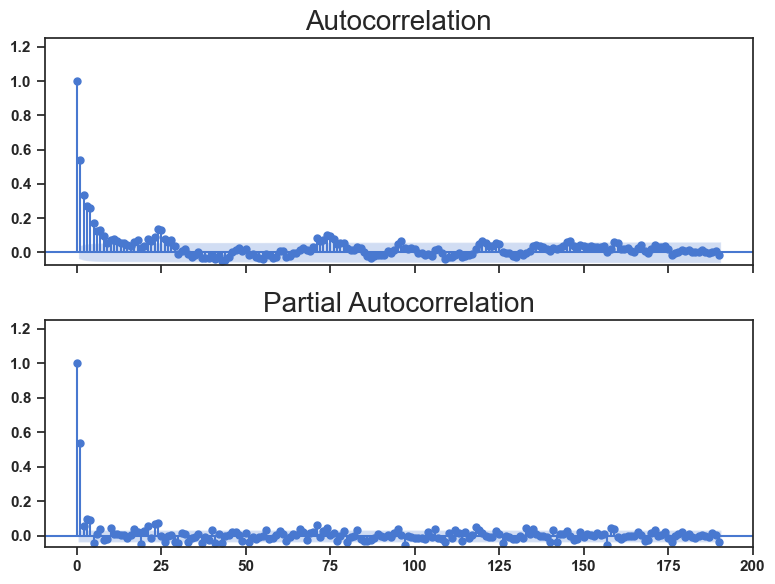

In [12]:
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(8, 6), sharex=True)

plot_acf(x=hourly_td['TD_resid'], lags=190, auto_ylims=True, ax=ax[0])
plot_pacf(x=hourly_td['TD_resid'], lags=190, auto_ylims=True, ax=ax[1]);

    Similar to the lag plots, the first lag has higher correlation compared to all other lags. Although Lag 2 shows some correlation, it is much weaker compared to first lag. Therefore, we will consider the first lag as a feature.